<a href="https://colab.research.google.com/github/Developer-AD/Yes_Bank_Price_Prediction/blob/main/Yes_Bank_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Import Important Libraries </b>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Remove Warnings.
import warnings
warnings.filterwarnings('ignore')

# <b>Exploratory Data Analysis</b>

<b>Mouting the drive</b>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Load csv file as data frame
csv_file_path = '/content/drive/MyDrive/AlmaBetter/CapstoneProject/Yes_Bank_Price_Prediction/data_YesBank_StockPrices.csv'
yes_bank = pd.read_csv(csv_file_path)

In [5]:
# Take quick look at the data structure
yes_bank.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [6]:
# Check shape of the data
yes_bank.shape

(185, 5)

###<b>A quick description of the data like how many non-null values are present in our data, it means we can also find null values from this non-null values, Data type of the feature and Total number of records</b>

In [7]:
# A quick description of the data
yes_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


###<b>As we can see that there is one 'object' data type are present that we need to convert in numerical data types because we can not process object data type to fit in the machine learning model. In machine learning model we can only fit numerical column.</b>

In [9]:
# Check for null values
yes_bank.isnull().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

###<b>We can conclude that there is no null values are present that good. We can good to go.</b>

In [10]:
# Summary of the Numerical features
yes_bank.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [11]:
# Summary of the Categorical features
yes_bank.describe(include='object')

,Date
count,185
unique,185
top,Jul-05
freq,1


In [12]:
# List of numeric features for plot the features
numeric_features = yes_bank.describe().columns
numeric_features

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

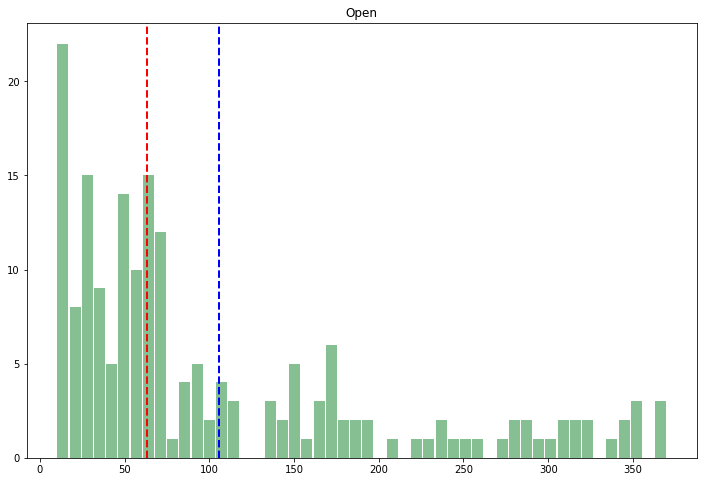

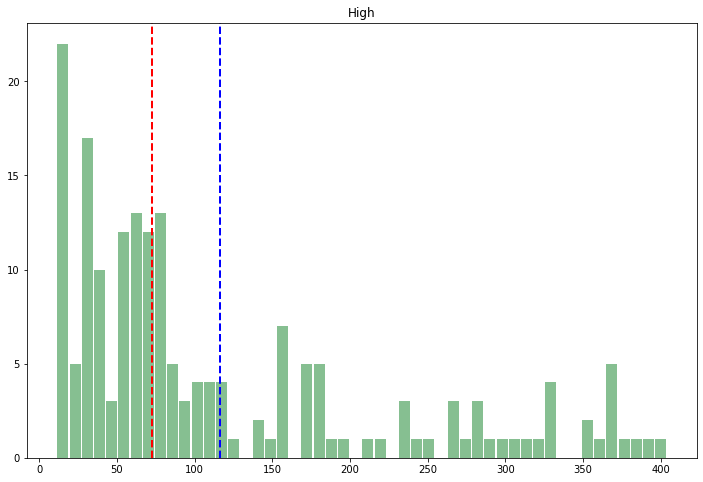

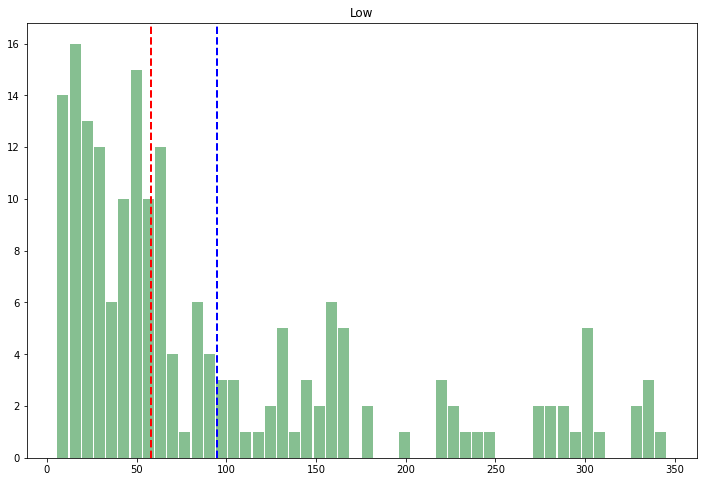

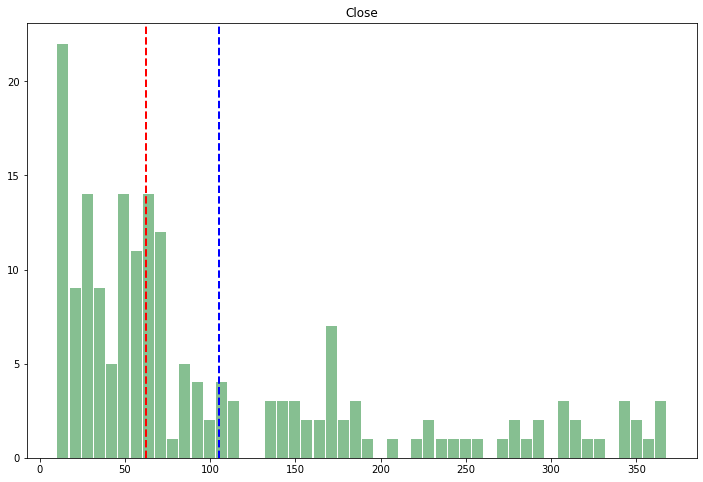

In [13]:
# Plot all features.
# plot a bar plot for each numerical feature count (except Date)

for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = yes_bank[col]
    feature.hist(bins=50, ax = ax , grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
    ax.axvline(feature.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='red', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

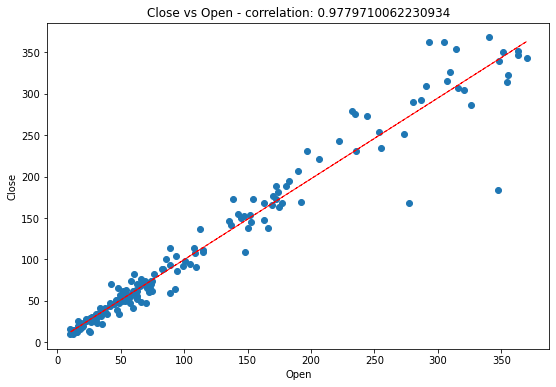

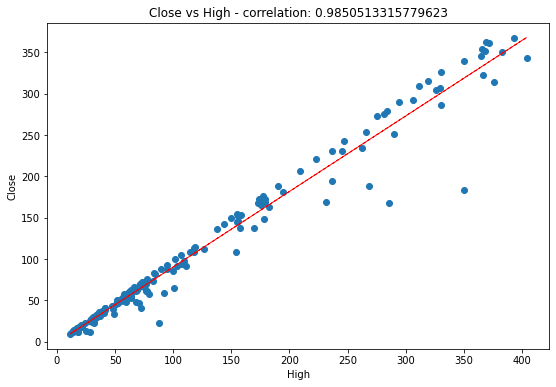

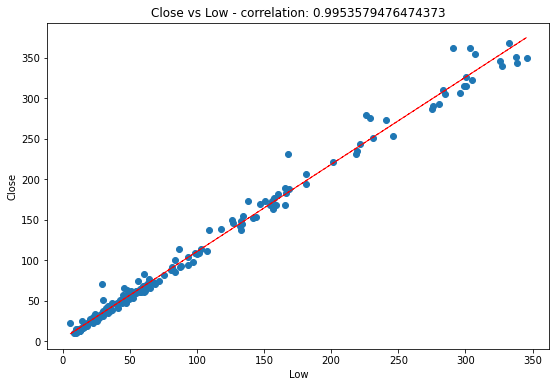

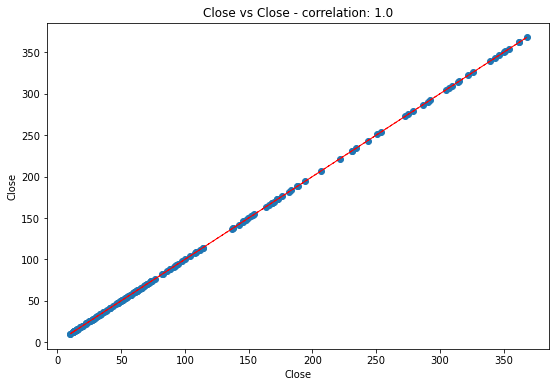

In [14]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = yes_bank[col]
    label = yes_bank['Close']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Close')
    ax.set_title('Close vs ' + col + ' - correlation: ' + str(correlation))
    z = np.polyfit(yes_bank[col], yes_bank['Close'], 1)
    y_hat = np.poly1d(z)(yes_bank[col])

    plt.plot(yes_bank[col], y_hat, "r--", lw=1)
plt.show()

###<b> Check Correlation

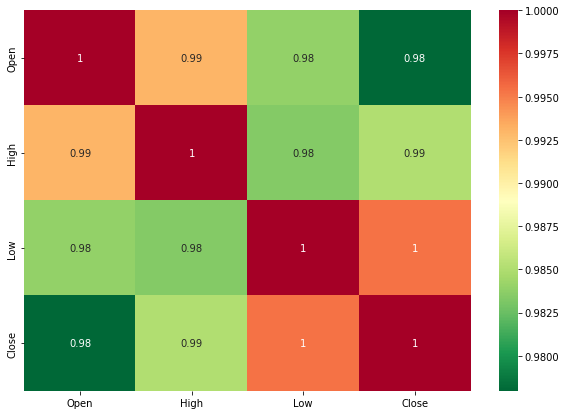

In [15]:
# Plot Correlation headtmap graph using seaborn
plt.figure(figsize=(10,7))
correlation = yes_bank.corr()
sns.heatmap(abs(correlation), annot=True, cmap = 'RdYlGn_r')
plt.show()

In [16]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [17]:
calc_vif(yes_bank[[i for i in yes_bank.describe().columns if i not in ['Date','Close']]])

,variables,VIF
0,Open,175.185704
1,High,167.057523
2,Low,71.574137


###<b> Handle Date Feature</b>

In [21]:
# Converting 'Date' feature from object type to datetime type
yes_bank['Date']=pd.to_datetime(yes_bank['Date'], format = '%b-%y')